In [1]:
import os
import numpy as np
import pandas as pd

In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 1000)

## I. EDA & Pre-processing

In [361]:
%run eda.py

In [362]:
%run preprocessing.py

### Accelerometer data

In [62]:
accl_raw = pd.read_csv("data/all_accelerometer_data_pids_13.csv")

In [234]:
accl_raw.pid.unique()

array(['JB3156', 'CC6740', 'SA0297', 'PC6771', 'BK7610', 'DC6359',
       'MC7070', 'MJ8002', 'BU4707', 'JR8022', 'HV0618', 'SF3079',
       'DK3500'], dtype=object)

In [359]:
get_min_max_interval(accl_raw)

,pid,Min Time Interval (ms),Median Time Interval (ms),Max Time Interval (ms)
0,JB3156,0.0,20.0,114899.0
1,CC6740,0.0,25.0,2157503.0
2,SA0297,0.0,45.0,9366095.0
3,PC6771,0.0,25.0,21320666.0
4,BK7610,0.0,25.0,825778.0
5,DC6359,0.0,25.0,8148762.0
6,MC7070,0.0,25.0,15147211.0
7,MJ8002,0.0,25.0,12773235.0
8,BU4707,0.0,25.0,6588017.0
9,JR8022,0.0,26.0,12233634.0


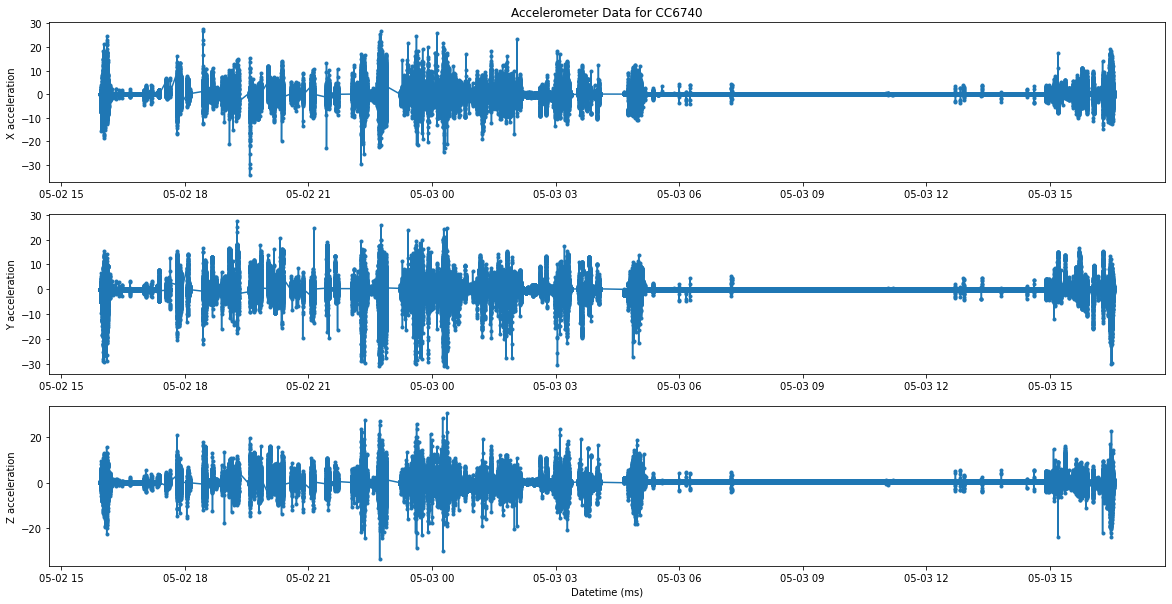

In [363]:
plot_acc_readings(accl_raw, 'CC6740')

### Pre-process accelerometer data

In [7]:
# Pre-process accelerometer data for each pid and save as pkl file.
path = "data/"
new_path = "preprocessed_data/"
preprocess_acc(path, new_path)

Preprocessing: SA0297
Original shape: (923451, 5)
1493733882409 1493824735776
New shape: (90853368, 5)
Preprocessing: PC6771
Original shape: (2073372, 5)
1493735288409 1493821488372
New shape: (86199964, 5)
Preprocessing: BK7610
Original shape: (1176530, 5)
1493735870653 1493767770640
New shape: (31899988, 5)
Preprocessing: DC6359
Original shape: (578394, 5)
1493736440950 1493769017080
New shape: (32576131, 5)
Preprocessing: MC7070
Original shape: (307866, 5)
1493736657665 1493781545272
New shape: (44887608, 5)
Preprocessing: MJ8002
Original shape: (613982, 5)
1493736949591 1493784951985
New shape: (48002395, 5)
Preprocessing: BU4707
Original shape: (443875, 5)
1493737404780 1493757822097
New shape: (20417318, 5)
Preprocessing: JR8022
Original shape: (299825, 5)
1493737962462 1493772061028
New shape: (34098567, 5)
Preprocessing: HV0618
Original shape: (1795520, 5)
1493738907489 1493825233785
New shape: (86326297, 5)
Preprocessing: SF3079
Original shape: (654301, 5)
1493739196712 149379

### TAC data

In [212]:
# Pre-process clean_tac data.
tac = preprocess_tac(path + "clean_tac/")

In [213]:
tac.head()

,timestamp,TAC_Reading,pid,intoxicated
0,1493716723,-0.010229,SA0297,0.0
1,1493717859,0.000043,PC6771,0.0
2,1493718546,-0.002512,SA0297,0.0
3,1493718714,-0.000482,BK7610,0.0
4,1493718714,-0.000482,BU4707,0.0


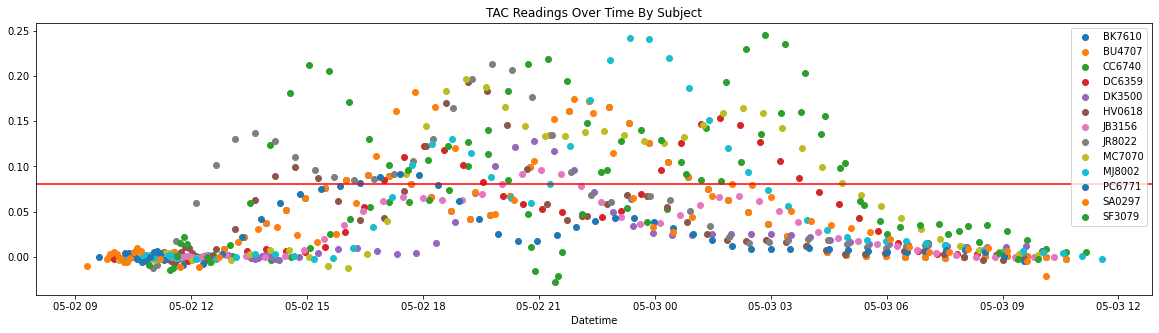

In [214]:
# Plot TAC readings over time by subject.
plot_tac_readings(tac)

In [215]:
tac = tac.drop(columns=['datetime', 'TAC_Reading'], axis=1)

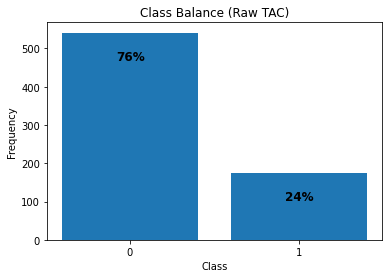

In [216]:
# Plot class balance.
plot_class_balance(tac,'Class Balance (Raw TAC)')

## II. Feature Engineering

In [21]:
%run feature_engineering.py

In [22]:
%%time

acc_path = "preprocessed_data/"
full_acc = run_feature_engineering(acc_path)

MC7070_preprocessed_acc.pkl
JR8022_preprocessed_acc.pkl
PC6771_preprocessed_acc.pkl
BK7610_preprocessed_acc.pkl
MJ8002_preprocessed_acc.pkl
SA0297_preprocessed_acc.pkl
DK3500_preprocessed_acc.pkl
DC6359_preprocessed_acc.pkl
SF3079_preprocessed_acc.pkl
HV0618_preprocessed_acc.pkl
JB3156_preprocessed_acc.pkl
CC6740_preprocessed_acc.pkl
BU4707_preprocessed_acc.pkl
CPU times: user 14min 23s, sys: 3min 49s, total: 18min 12s
Wall time: 18min 47s


In [34]:
# Join target onto features.
merged = reconcile_acc_tac(full_acc, tac)

In [40]:
merged.shape

(72521, 139)

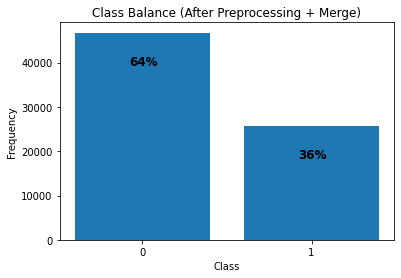

In [217]:
# Class balance after merge.
plot_class_balance(merged,'Class Balance (After Preprocessing + Merge)')

## III. Train-valid-test split

In [56]:
%run models.py

In [38]:
train_X, valid_X, test_X, train_y, valid_y, test_y = split_dataset(merged)

In [39]:
# Save train and test data for H2o AutoML.
h2o_train_X = pd.concat([train_X, valid_X])
h2o_train_y = pd.concat([train_y, valid_y])
h2o_train = h2o_train_X.join(h2o_train_y).reset_index(drop=True)
h2o_train.to_csv("h2o_data/train.csv", index=False)

h2o_test = test_X.join(test_y).reset_index(drop=True)
h2o_test.to_csv("h2o_data/test.csv", index=False)

In [41]:
h2o_test.shape

(10879, 136)

In [42]:
h2o_train.shape

(61642, 136)

## VI. Baseline RF Model

In [59]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100,
                            min_samples_leaf=5,
                            n_jobs=-1,
                            oob_score=True)


In [60]:
%%time
rf.fit(train_X, train_y)

/Users/lisachua/anaconda3/envs/detect_heavy_drinking/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


CPU times: user 33.5 s, sys: 253 ms, total: 33.8 s
Wall time: 10.1 s


RandomForestClassifier(min_samples_leaf=5, n_jobs=-1, oob_score=True)

In [61]:
%%time
y_prob = rf.predict(test_X)

CPU times: user 237 ms, sys: 23.7 ms, total: 261 ms
Wall time: 250 ms


In [52]:
y_pred = np.where(y_prob > 0.5, 1, 0)
print(f"Accuracy: {accuracy_score(test_y, y_pred)}")
print(f"F1 Score: {f1_score(test_y, y_pred)}")

Accuracy: 0.8563287066825995
F1 Score: 0.7987121699935609


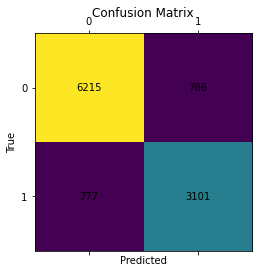

In [57]:
plot_confusion_matrix(test_y, y_pred)

## V. Feature Importance

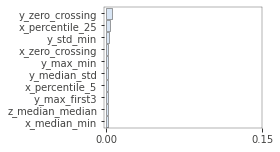

In [48]:
from rfpimp import *
imp = importances(rf, valid_X, valid_y, n_samples=-1)
viz = plot_importances(imp[:10])
viz.view()